## What is Seq2Seq Modelling?

- **Sequence-to-sequence learning (Seq2Seq)** is about training models to convert sequences from one domain (e.g., sentences in English) to sequences in another domain (e.g., the same sentences translated to German). Our aim is to translate given sentences from German to English.
- Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.
- Here, both the input and output are sentences, meaning these sentences are a sequence of words going in and out of a model. This is the basic idea of Sequence-to-Sequence modeling. The figure below explains this method.

<p align="center">
  <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/enc_dec_simple.png" alt="Seq2Seq Model">
</p>

### Here's how it works:

- Feed the embedding vectors for source sequences (German) to the encoder network, one word at a time.
- Encode the input sentences into fixed-dimension state vectors. At this step, we get the hidden and cell states from the encoder LSTM and feed them to the decoder LSTM.
- These states are regarded as initial states by the decoder. Additionally, it also has the embedding vectors for target words (English).
- Decode and output the translated sentence, one word at a time. In this step, the output of the decoder is sent to a softmax layer over the entire target vocabulary.

## What is LSTM?

- **Long Short-Term Memory (LSTM)** networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNNs is resolved here. LSTM is well-suited to classify, process, and predict time series with time lags of unknown duration. It trains the model using back-propagation. In an LSTM network, three gates are present:

<p align="center">
  <img src="https://miro.medium.com/max/700/1*MwU5yk8f9d6IcLybvGgNxA.jpeg" alt="LSTM Model">
</p>

- **Input gate** — Determines which value from input should be used to modify the memory. The sigmoid function decides which values to let through (0 or 1), while the tanh function assigns weight to the values, deciding their importance, with values ranging from -1 to 1.

<p align="center">
  <img src="https://miro.medium.com/max/500/1*k1lxwjsxxn8O4BEiVlQNdg.png" alt="LSTM Input Gate">
</p>

- **Forget gate** — Determines what details to discard from the block. It is decided by the sigmoid function. It looks at the previous state (ht-1) and the current input (Xt), outputting a number between 0 (omit) and 1 (keep) for each number in the cell state Ct−1.

<p align="center">
  <img src="https://miro.medium.com/max/500/1*bQnecA5sy_eepNkL8I-95A.png" alt="LSTM Forget Gate">
</p>

- **Output gate** — Uses the input and memory of the block to determine the output. The sigmoid function decides which values to let through (0 or 1), while the tanh function assigns importance to values, ranging from -1 to 1, which are then multiplied with the output of the sigmoid function.

<p align="center">
  <img src="https://miro.medium.com/max/700/1*s8532P11PgGi2sZqikZ2kA.png" alt="LSTM Output Gate">
</p>


### Import the Required Libraries

In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Load the Data

In [6]:
# function to read raw text file
def read_text(filename, lines):
    # Read till number of lines
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read().split('\n')
    return text[:lines]

In [11]:
data = read_text("../data/test.tsv", 10000)
en_de = array([i.split('\t') for i in data])

### Text Cleaning / Preprocessing
We will get rid of the punctuation marks and then convert all the text to lower case

In [13]:
# Remove punctuation
en_de[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_de[:,0]]
en_de[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in en_de[:,1]]

en_de

array([['de', 'en'],
       ['Ursprünglich war die Schulhofsanierung sogar schon in den Jahren 20082009 geplant doch hohe unplanmäßige Ausgaben brachten eine Verschiebung',
        'The school yard renovation was originally planned back in 20082009 however high unplanned expenses meant that the work had to be pushed back'],
       ['Von daher werden sie gegen ihren ExCoach sicher ganz besonders motiviert sein',
        'Consequently they will be particularly motivated playing against their former coach'],
       ...,
       ['Die Nachrichten über diese Untersuchungen hat die Händler in einem Bereich in Aufruhr versetzt der in den letzten Jahren zu einem der profitabelsten der TradingEinheiten von Investmentbanken gehört hat aber dieses Jahr unter Druck stand weil niedrige Volatilität bei Währungen die Chancen für Spekulanten einschränkt',
        'News about the probes has rattled traders in an area that has been one of the bigger profit drivers of investment banks trading units in pas

In [14]:
# convert text to lowercase
for i in range(len(en_de)):
    en_de[i,0] = en_de[i,0].lower()
    en_de[i,1] = en_de[i,1].lower()

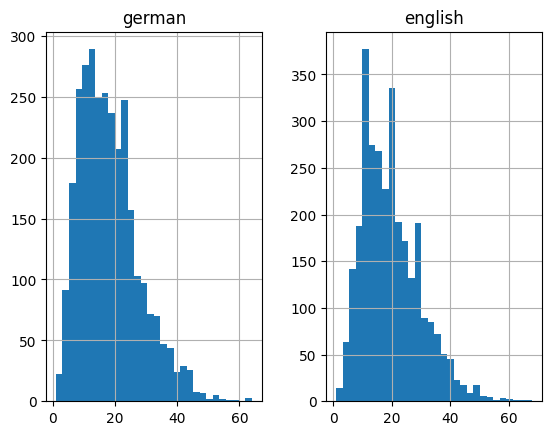

In [16]:
german = []
english = []

# populate the lists with sentence lengths
for i in en_de[:,0]:
      german.append(len(i.split()))

for i in en_de[:,1]:
      english.append(len(i.split()))

length_df = pd.DataFrame({'german':german, 'english':english})

length_df.hist(bins = 30)
plt.show()

- A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length
- Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length
- Prepare tokenizers for both the German and English sentences

In [17]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(en_de[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13562


In [19]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(en_de[:, 0])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutsch Vocabulary Size: %d' % deu_vocab_size)

Deutsch Vocabulary Size: 13562


- We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.
- When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.

In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

- When we feed our sequences of word IDs into the model, each sequence needs to be the same length. To achieve this, padding is added to any sequence that is shorter than the max length (i.e. shorter than the longest sentence).

<center><img src="https://miro.medium.com/max/1728/0*6jZTOE0P7_i7N8pn.png"></center>

- Inputs. Input sequences are fed into the model with one word for every time step. Each word is encoded as a unique integer so that it maps to the German dataset vocabulary.
- Embedding Layers. Embeddings are used to convert each word to a vector. The size of the vector depends on the complexity of the vocabulary.
- LSTM Layer (Encoder). This is where the context from word vectors in previous time steps is applied to the current word vector.
- Dense Layers (Decoder). These are typical fully connected layers used to decode the encoded input into the correct translation sequence.
- The outputs are returned as a sequence of integers or one-hot encoded vectors which can then be mapped to the English dataset vocabulary.
    
    
<center><h1 style="font-size:150%;">Model Architecture</h1></center>
<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/architecture.png"></center>

In [22]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(en_de, test_size=0.2, random_state = 12)

- It’s time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.

In [23]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

### Define the Model

In [24]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [26]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [29]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

- We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.
- Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.
               

### Fit the Model

In [32]:
filename = 'model.1.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30


2024-11-12 00:10:03.739476: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 9.5139
Epoch 1: val_loss improved from inf to 9.50915, saving model to model.1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 9.5136 - val_loss: 9.5091
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 9.5078
Epoch 2: val_loss improved from 9.50915 to 9.50338, saving model to model.1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - loss: 9.5077 - val_loss: 9.5034
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 9.5013
Epoch 3: val_loss improved from 9.50338 to 9.49449, saving model to model.1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 9.5010 - val_loss: 9.4945
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 9.4911
Epoch 4: val_loss improved from 9.49449 to 9.47787, saving model to model.1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - loss: 9.4906 - val_loss: 9.4779
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 9.4717
Epoch 5: val_loss improved from 9.47787 to 9.43898, saving model to model.1.keras
4/4 ━━━━━━━

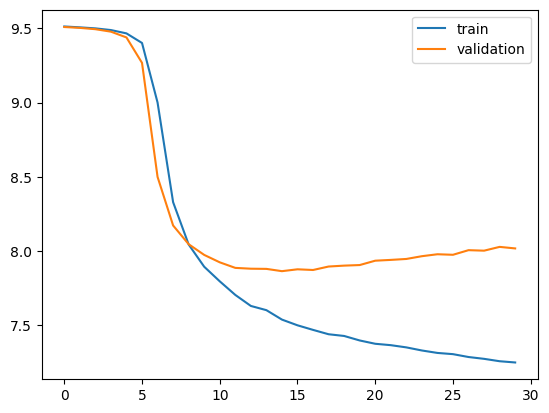

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Prediction on unseen data

In [36]:
model = load_model('model.1.keras')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = argmax(preds, axis=2)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [37]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [38]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [40]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,johannes kana war bereits anfang der woche des verbrechens für schuldig befunden worden,die der
1,man könnte sagen dass new york city die geburtsstätte von standup comedy in amerika ist vor knapp hundert jahren fing der varietekünstler frank fay der als conférencier im palace theatre am broadw...,die der
2,der schuss kam aus einem kleinwagen der an einer gruppe von sechs kindern vorbeigefahren war und plötzlich angehalten hatte,die der
3,er sagt obama habe lobenswerte bemühungen unternommen die von der blockadetaktik der republikaner vereitelt worden seien,die
4,im bundestag wurde vorgeschlagen wir sollten ein deutsches google aufbauen,die der
5,das einzige was wir nicht konsumieren möchten ist das zuckersüße candy corn dennoch werden 15 millionen kilogramm davon um halloween verkauft so der nationale verband der süßwarenhersteller,die der
6,im rahmen des jubiläums sind etliche veranstaltungen sowohl in geisingen als auch in kirchenhausen geplant,die der
7,des weiteren lassen sich an beiden veranstaltungstagen von 11 bis 17 uhr zahlreiche handwerker wie der besenbinder die näherin die spinnerin die weberin und die bäckerin bei ihrer traditionellen a...,die der
8,das thema hebesätze müssen wir uns anschauen da in den kommenden jahren investitionen anstehen für die wir gerne zuschüsse hätten kündigte gerster in diesem zusammenhang an,die der
9,traditionell ist das stiftungsfest auch immer die passende festivität um ehrungen vorzunehmen,die der
